In [1]:
# AeroCNN-I
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import datetime
%matplotlib inline

In [2]:
n_kernel=512
n_units=512
l2Regularizer=1e-09
kernel_size1 = 2
kernel_size2 = 5
n_grid = 101
strides = 2
input_size = 49

In [3]:
alpha = np.linspace(-10,20,16).reshape((16,1))

In [4]:
aa = np.zeros((16*133,1))
for i in range(0, 133):
    aa[16*i:16*(i+1), :] = alpha[:,:]

In [5]:
aa = aa.reshape((133, 16, 1, 1))

In [6]:
os.chdir('D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out')

In [7]:
origin = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_data = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"

In [8]:
folders_orig = os.listdir(origin_data)
folders = [file for file in folders_orig if file.startswith('airfoil')]

In [9]:
coord_df = pd.DataFrame()
counter = 1
for i in range(1, 134):
    coord_file_name = origin_coord + "\\airfoil" + str(i) + "\\airfoilOut"+ str(i) + ".txt"
    data = pd.read_csv(coord_file_name, sep = ",", header=None)
    while counter < 17:
        coord_df = pd.concat([coord_df, data], axis=0)
        counter += 1
    counter=1

In [10]:
coord_np = coord_df.iloc[:, :].values

In [11]:
coord = coord_np.reshape((len(folders), 16, 2, 50))

In [12]:
cl_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cl_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cl_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cl_name, sep = ",", header=None)
        cl_df = pd.concat([cl_df, data], axis=0)

In [13]:
cd_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cd_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cd_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cd_name, sep = ",", header=None)
        cd_df = pd.concat([cd_df, data], axis=0)

In [14]:
cl = cl_df.iloc[:, :].values.reshape((-1,1))
cd = cd_df.iloc[:, :].values.reshape((-1,1))
y = np.hstack((cl, cd))

In [15]:
y = y.reshape((133, 16, 2, 1))

In [16]:
file_name = origin_data + "\\AirfoilIndexList.xlsx"
airfoilName_df = pd.read_excel(file_name)
geometry_orig = airfoilName_df.iloc[:, 1].values

In [17]:
geometry = np.zeros((133*16,1))
geometry = geometry.astype(np.string_)
for i in geometry_orig:
    index_ = np.where(geometry_orig==i)
    for j in range(0,16):
        geometry[16*index_[0]+j,:] = np.asarray(i)

In [18]:
geometry.shape

(2128, 1)

In [19]:
geometry = geometry.reshape((133, 16, 1))

In [20]:
x_train, x_test, aa_train, aa_test, geo_train, geo_test, y_train, y_test = train_test_split(coord, aa, geometry, y, test_size=0.3, random_state=1)

In [21]:
x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2], x_train.shape[3], 1))
x_test = x_test.reshape((x_test.shape[0]*x_test.shape[1], x_test.shape[2], x_test.shape[3], 1))
aa_train = aa_train.reshape((aa_train.shape[0]*aa_train.shape[1], aa_train.shape[2], aa_train.shape[3]))
aa_test = aa_test.reshape((aa_test.shape[0]*aa_test.shape[1], aa_test.shape[2], aa_test.shape[3]))
geo_train = geo_train.reshape((geo_train.shape[0]*geo_train.shape[1], geo_train.shape[2]))
geo_test = geo_test.reshape((geo_test.shape[0]*geo_test.shape[1], geo_test.shape[2]))
y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1], y_train.shape[2], y_train.shape[3]))
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1], y_test.shape[2], y_test.shape[3]))

In [22]:
input_coord = tf.keras.Input(shape=(2, 50, 1))
input_alpha = tf.keras.Input(shape=(1,1))

x_conv = tf.keras.layers.Conv2D(n_kernel, (kernel_size1, kernel_size2), strides=(strides, strides),
                                activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                name='Conv2DLayer')(input_coord)
x_ = tf.keras.layers.MaxPooling2D((1,2))(x_conv)
reshape1 = tf.keras.layers.Flatten()(x_)
reshape2 = tf.keras.layers.Reshape((1,))(input_alpha)
x_concat = tf.keras.layers.Concatenate(axis=1)([reshape1, reshape2])

x_ = tf.keras.layers.Dense(units=200, activation='relu', name='firstHiddenLayerSensor',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_concat)
x_ = tf.keras.layers.Dense(units=100, activation='relu', name='secondHiddenLayerSensor',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_)

output_data = tf.keras.layers.Dense(units=2, activation=None, name='outputLayerSensor')(x_)
output_image = tf.keras.layers.Reshape((2, 1))(output_data)
# AeroCNN-I
model = tf.keras.Model([input_coord, input_alpha], output_image)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 50, 1)]   0           []                               
                                                                                                  
 Conv2DLayer (Conv2D)           (None, 1, 25, 512)   5632        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 1, 12, 512)   0           ['Conv2DLayer[0][0]']            
                                                                                                  
 input_2 (InputLayer)           [(None, 1, 1)]       0           []                               
                                                                                              

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [25]:
start = datetime.datetime.now()
history = model.fit([x_train,aa_train], y_train, epochs=5000, shuffle=True)
end = datetime.datetime.now()

Epoch 1/5000
47/47 [==============================] - 5s 8ms/step - loss: 0.0332 - rmse: 0.1822
Epoch 2/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0107 - rmse: 0.1036
Epoch 3/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0102 - rmse: 0.1012
Epoch 4/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0095 - rmse: 0.0973
Epoch 5/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0101 - rmse: 0.1004
Epoch 6/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0084 - rmse: 0.0917
Epoch 7/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0083 - rmse: 0.0911
Epoch 8/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0091 - rmse: 0.0954
Epoch 9/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0079 - rmse: 0.0889
Epoch 10/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0081 - rmse: 0.0902
Epoch 11/5000
47/47 [==================

47/47 [==============================] - 0s 5ms/step - loss: 0.0045 - rmse: 0.0669
Epoch 86/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0049 - rmse: 0.0699
Epoch 87/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0045 - rmse: 0.0671
Epoch 88/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0047 - rmse: 0.0686
Epoch 89/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0050 - rmse: 0.0709
Epoch 90/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0053 - rmse: 0.0728
Epoch 91/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0050 - rmse: 0.0707
Epoch 92/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0048 - rmse: 0.0690
Epoch 93/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0047 - rmse: 0.0684
Epoch 94/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0047 - rmse: 0.0686
Epoch 95/5000
47/47 [=======================

47/47 [==============================] - 0s 5ms/step - loss: 0.0040 - rmse: 0.0631
Epoch 169/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0035 - rmse: 0.0595
Epoch 170/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0037 - rmse: 0.0611
Epoch 171/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0037 - rmse: 0.0609
Epoch 172/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0039 - rmse: 0.0622
Epoch 173/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0040 - rmse: 0.0635
Epoch 174/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0036 - rmse: 0.0599
Epoch 175/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0036 - rmse: 0.0600
Epoch 176/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0041 - rmse: 0.0638
Epoch 177/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0038 - rmse: 0.0620
Epoch 178/5000
47/47 [=============

47/47 [==============================] - 0s 5ms/step - loss: 0.0028 - rmse: 0.0527
Epoch 252/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0029 - rmse: 0.0536
Epoch 253/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0032 - rmse: 0.0565
Epoch 254/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0033 - rmse: 0.0574
Epoch 255/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0030 - rmse: 0.0547
Epoch 256/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0029 - rmse: 0.0537
Epoch 257/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0029 - rmse: 0.0536
Epoch 258/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0030 - rmse: 0.0543
Epoch 259/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0029 - rmse: 0.0540
Epoch 260/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0030 - rmse: 0.0545
Epoch 261/5000
47/47 [=============

47/47 [==============================] - 0s 7ms/step - loss: 0.0030 - rmse: 0.0549
Epoch 335/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0022 - rmse: 0.0473
Epoch 336/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0022 - rmse: 0.0473
Epoch 337/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0021 - rmse: 0.0462
Epoch 338/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0022 - rmse: 0.0468
Epoch 339/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0023 - rmse: 0.0476
Epoch 340/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0023 - rmse: 0.0483
Epoch 341/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0024 - rmse: 0.0486
Epoch 342/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0022 - rmse: 0.0467
Epoch 343/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0021 - rmse: 0.0461
Epoch 344/5000
47/47 [=============

47/47 [==============================] - 0s 5ms/step - loss: 0.0023 - rmse: 0.0478
Epoch 418/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0020 - rmse: 0.0443
Epoch 419/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0018 - rmse: 0.0421
Epoch 420/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0018 - rmse: 0.0428
Epoch 421/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0016 - rmse: 0.0401
Epoch 422/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0019 - rmse: 0.0434
Epoch 423/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0019 - rmse: 0.0431
Epoch 424/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0021 - rmse: 0.0454
Epoch 425/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0017 - rmse: 0.0415
Epoch 426/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0018 - rmse: 0.0424
Epoch 427/5000
47/47 [=============

47/47 [==============================] - 0s 5ms/step - loss: 0.0015 - rmse: 0.0383
Epoch 501/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0015 - rmse: 0.0389
Epoch 502/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0015 - rmse: 0.0393
Epoch 503/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0019 - rmse: 0.0434
Epoch 504/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0013 - rmse: 0.0367
Epoch 505/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0014 - rmse: 0.0370
Epoch 506/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0016 - rmse: 0.0403
Epoch 507/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0017 - rmse: 0.0410
Epoch 508/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0014 - rmse: 0.0380
Epoch 509/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0015 - rmse: 0.0383
Epoch 510/5000
47/47 [=============

47/47 [==============================] - 0s 5ms/step - loss: 0.0016 - rmse: 0.0397
Epoch 584/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0013 - rmse: 0.0363
Epoch 585/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0013 - rmse: 0.0353
Epoch 586/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0328
Epoch 587/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0013 - rmse: 0.0362
Epoch 588/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0014 - rmse: 0.0374
Epoch 589/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0010 - rmse: 0.0322
Epoch 590/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0010 - rmse: 0.0323
Epoch 591/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0016 - rmse: 0.0401
Epoch 592/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0016 - rmse: 0.0394
Epoch 593/5000
47/47 [=============

47/47 [==============================] - 0s 5ms/step - loss: 9.3580e-04 - rmse: 0.0305
Epoch 667/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0015 - rmse: 0.0387
Epoch 668/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0010 - rmse: 0.0317
Epoch 669/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.9198e-04 - rmse: 0.0314
Epoch 670/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0010 - rmse: 0.0316
Epoch 671/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0010 - rmse: 0.0321
Epoch 672/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0010 - rmse: 0.0317
Epoch 673/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.8315e-04 - rmse: 0.0279
Epoch 674/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.4767e-04 - rmse: 0.0272
Epoch 675/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.2760e-04 - rmse: 0.0287
Epoch 676/5000


47/47 [==============================] - 0s 7ms/step - loss: 7.5122e-04 - rmse: 0.0273
Epoch 748/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.3801e-04 - rmse: 0.0289
Epoch 749/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.7923e-04 - rmse: 0.0260
Epoch 750/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.7256e-04 - rmse: 0.0258
Epoch 751/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.9321e-04 - rmse: 0.0262
Epoch 752/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.0160e-04 - rmse: 0.0282
Epoch 753/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.4864e-04 - rmse: 0.0254
Epoch 754/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.3646e-04 - rmse: 0.0270
Epoch 755/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0013 - rmse: 0.0362
Epoch 756/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.7782e-04 - rmse: 0.0295

47/47 [==============================] - 0s 5ms/step - loss: 4.9553e-04 - rmse: 0.0221
Epoch 829/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.6405e-04 - rmse: 0.0236
Epoch 830/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.8749e-04 - rmse: 0.0241
Epoch 831/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.2350e-04 - rmse: 0.0249
Epoch 832/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0022 - rmse: 0.0469
Epoch 833/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0028 - rmse: 0.0531
Epoch 834/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0025 - rmse: 0.0496
Epoch 835/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0016 - rmse: 0.0402
Epoch 836/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0324
Epoch 837/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.0269e-04 - rmse: 0.0282
Epoch 838/5000


47/47 [==============================] - 0s 5ms/step - loss: 5.1207e-04 - rmse: 0.0225
Epoch 910/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.9901e-04 - rmse: 0.0222
Epoch 911/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.2632e-04 - rmse: 0.0228
Epoch 912/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.8448e-04 - rmse: 0.0219
Epoch 913/5000
47/47 [==============================] - 0s 7ms/step - loss: 5.0176e-04 - rmse: 0.0223
Epoch 914/5000
47/47 [==============================] - 0s 6ms/step - loss: 5.4121e-04 - rmse: 0.0231
Epoch 915/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.1614e-04 - rmse: 0.0226
Epoch 916/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.6139e-04 - rmse: 0.0236
Epoch 917/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.1279e-04 - rmse: 0.0225
Epoch 918/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.7895e-04 - rmse: 0.

47/47 [==============================] - 0s 6ms/step - loss: 4.7544e-04 - rmse: 0.0217
Epoch 991/5000
47/47 [==============================] - 0s 7ms/step - loss: 4.2964e-04 - rmse: 0.0206
Epoch 992/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.9291e-04 - rmse: 0.0197
Epoch 993/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.9912e-04 - rmse: 0.0222
Epoch 994/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.2816e-04 - rmse: 0.0205
Epoch 995/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.9528e-04 - rmse: 0.0197
Epoch 996/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.2539e-04 - rmse: 0.0205
Epoch 997/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.6090e-04 - rmse: 0.0213
Epoch 998/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.1600e-04 - rmse: 0.0226
Epoch 999/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.9089e-04 - rmse: 0.

47/47 [==============================] - 0s 7ms/step - loss: 3.9842e-04 - rmse: 0.0198
Epoch 1070/5000
47/47 [==============================] - 0s 7ms/step - loss: 4.9101e-04 - rmse: 0.0220
Epoch 1071/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.9147e-04 - rmse: 0.0220
Epoch 1072/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.3231e-04 - rmse: 0.0250
Epoch 1073/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.5850e-04 - rmse: 0.0255
Epoch 1074/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0025 - rmse: 0.0498
Epoch 1075/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0041 - rmse: 0.0639
Epoch 1076/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0021 - rmse: 0.0452
Epoch 1077/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0017 - rmse: 0.0410
Epoch 1078/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0019 - rmse: 0.0432
Epoch 

47/47 [==============================] - 0s 7ms/step - loss: 4.2337e-04 - rmse: 0.0204
Epoch 1150/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0018 - rmse: 0.0420
Epoch 1151/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0028 - rmse: 0.0527
Epoch 1152/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0031 - rmse: 0.0560
Epoch 1153/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0014 - rmse: 0.0376
Epoch 1154/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0016 - rmse: 0.0405
Epoch 1155/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0016 - rmse: 0.0403
Epoch 1156/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.2199e-04 - rmse: 0.0303
Epoch 1157/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.5262e-04 - rmse: 0.0291
Epoch 1158/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.9967e-04 - rmse: 0.0222
Epoch 1159

47/47 [==============================] - 0s 5ms/step - loss: 4.3291e-04 - rmse: 0.0206
Epoch 1229/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.4105e-04 - rmse: 0.0208
Epoch 1230/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.4144e-04 - rmse: 0.0208
Epoch 1231/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.5524e-04 - rmse: 0.0274
Epoch 1232/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.0201e-04 - rmse: 0.0282
Epoch 1233/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.3293e-04 - rmse: 0.0250
Epoch 1234/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.0569e-04 - rmse: 0.0300
Epoch 1235/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0013 - rmse: 0.0355
Epoch 1236/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.7313e-04 - rmse: 0.0258
Epoch 1237/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.3594e-04 - rms

47/47 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0339
Epoch 1309/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.6064e-04 - rmse: 0.0275
Epoch 1310/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.3886e-04 - rmse: 0.0208
Epoch 1311/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.6482e-04 - rmse: 0.0189
Epoch 1312/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.4834e-04 - rmse: 0.0185
Epoch 1313/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.2865e-04 - rmse: 0.0179
Epoch 1314/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.3159e-04 - rmse: 0.0180
Epoch 1315/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.0735e-04 - rmse: 0.0173
Epoch 1316/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.1224e-04 - rmse: 0.0175
Epoch 1317/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.8954e-04 - rms

47/47 [==============================] - 0s 7ms/step - loss: 4.2004e-04 - rmse: 0.0203
Epoch 1388/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.7666e-04 - rmse: 0.0192
Epoch 1389/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.5620e-04 - rmse: 0.0212
Epoch 1390/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.0410e-04 - rmse: 0.0199
Epoch 1391/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.0076e-04 - rmse: 0.0198
Epoch 1392/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.4691e-04 - rmse: 0.0184
Epoch 1393/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.4561e-04 - rmse: 0.0184
Epoch 1394/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.4251e-04 - rmse: 0.0183
Epoch 1395/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.9948e-04 - rmse: 0.0171
Epoch 1396/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.3054e-04 -

47/47 [==============================] - 0s 7ms/step - loss: 3.6569e-04 - rmse: 0.0189
Epoch 1468/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.2147e-04 - rmse: 0.0177
Epoch 1469/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.4078e-04 - rmse: 0.0153
Epoch 1470/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.1806e-04 - rmse: 0.0145
Epoch 1471/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.6857e-04 - rmse: 0.0162
Epoch 1472/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.2011e-04 - rmse: 0.0146
Epoch 1473/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.3705e-04 - rmse: 0.0152
Epoch 1474/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.3665e-04 - rmse: 0.0151
Epoch 1475/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.5655e-04 - rmse: 0.0158
Epoch 1476/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.7901e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 2.1129e-04 - rmse: 0.0143
Epoch 1548/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.3413e-04 - rmse: 0.0151
Epoch 1549/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.0006e-04 - rmse: 0.0139
Epoch 1550/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.1868e-04 - rmse: 0.0145
Epoch 1551/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.0138e-04 - rmse: 0.0139
Epoch 1552/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.0244e-04 - rmse: 0.0140
Epoch 1553/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.9350e-04 - rmse: 0.0136
Epoch 1554/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.2726e-04 - rmse: 0.0148
Epoch 1555/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.7847e-04 - rmse: 0.0131
Epoch 1556/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.9620e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 3.7891e-04 - rmse: 0.0193
Epoch 1627/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0347
Epoch 1628/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0023 - rmse: 0.0481
Epoch 1629/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0037 - rmse: 0.0609
Epoch 1630/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0026 - rmse: 0.0505
Epoch 1631/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0018 - rmse: 0.0423
Epoch 1632/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0337
Epoch 1633/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.8587e-04 - rmse: 0.0260
Epoch 1634/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.1276e-04 - rmse: 0.0225
Epoch 1635/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.4512e-04 - rmse: 0.0209
Epoch 1636

47/47 [==============================] - 0s 6ms/step - loss: 2.1172e-04 - rmse: 0.0143
Epoch 1707/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.1510e-04 - rmse: 0.0144
Epoch 1708/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.1448e-04 - rmse: 0.0144
Epoch 1709/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.4196e-04 - rmse: 0.0153
Epoch 1710/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.1690e-04 - rmse: 0.0145
Epoch 1711/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.2071e-04 - rmse: 0.0146
Epoch 1712/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.1866e-04 - rmse: 0.0145
Epoch 1713/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.0137e-04 - rmse: 0.0139
Epoch 1714/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.2167e-04 - rmse: 0.0146
Epoch 1715/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.8914e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 1.9360e-04 - rmse: 0.0136
Epoch 1786/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.7052e-04 - rmse: 0.0128
Epoch 1787/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.6894e-04 - rmse: 0.0127
Epoch 1788/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.9139e-04 - rmse: 0.0136
Epoch 1789/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.8152e-04 - rmse: 0.0132
Epoch 1790/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.8677e-04 - rmse: 0.0134
Epoch 1791/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.9510e-04 - rmse: 0.0137
Epoch 1792/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.9345e-04 - rmse: 0.0136
Epoch 1793/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.0273e-04 - rmse: 0.0140
Epoch 1794/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.0530e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 3.9857e-04 - rmse: 0.0198
Epoch 1865/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.9091e-04 - rmse: 0.0220
Epoch 1866/5000
47/47 [==============================] - 0s 7ms/step - loss: 5.0785e-04 - rmse: 0.0224
Epoch 1867/5000
47/47 [==============================] - 0s 6ms/step - loss: 4.4235e-04 - rmse: 0.0208
Epoch 1868/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.5969e-04 - rmse: 0.0213
Epoch 1869/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.9155e-04 - rmse: 0.0261
Epoch 1870/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.7342e-04 - rmse: 0.0216
Epoch 1871/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.4081e-04 - rmse: 0.0208
Epoch 1872/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.2918e-04 - rmse: 0.0179
Epoch 1873/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.8314e-04 -

47/47 [==============================] - 0s 7ms/step - loss: 1.8660e-04 - rmse: 0.0134
Epoch 1944/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.4879e-04 - rmse: 0.0155
Epoch 1945/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.4086e-04 - rmse: 0.0153
Epoch 1946/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.4893e-04 - rmse: 0.0155
Epoch 1947/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.7560e-04 - rmse: 0.0164
Epoch 1948/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.1932e-04 - rmse: 0.0176
Epoch 1949/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.2623e-04 - rmse: 0.0205
Epoch 1950/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.6336e-04 - rmse: 0.0236
Epoch 1951/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.4165e-04 - rmse: 0.0208
Epoch 1952/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.5207e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 1.5321e-04 - rmse: 0.0121
Epoch 2023/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.9507e-04 - rmse: 0.0137
Epoch 2024/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.7503e-04 - rmse: 0.0163
Epoch 2025/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.5973e-04 - rmse: 0.0159
Epoch 2026/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.1115e-04 - rmse: 0.0143
Epoch 2027/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.7634e-04 - rmse: 0.0130
Epoch 2028/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.0319e-04 - rmse: 0.0140
Epoch 2029/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.2849e-04 - rmse: 0.0149
Epoch 2030/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.2046e-04 - rmse: 0.0146
Epoch 2031/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.1022e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 2.3823e-04 - rmse: 0.0152
Epoch 2102/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.3248e-04 - rmse: 0.0150
Epoch 2103/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.4782e-04 - rmse: 0.0155
Epoch 2104/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.1256e-04 - rmse: 0.0143
Epoch 2105/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.4920e-04 - rmse: 0.0155
Epoch 2106/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.7752e-04 - rmse: 0.0164
Epoch 2107/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.4048e-04 - rmse: 0.0152
Epoch 2108/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.7659e-04 - rmse: 0.0164
Epoch 2109/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.8204e-04 - rmse: 0.0166
Epoch 2110/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.9936e-04 -

47/47 [==============================] - 0s 7ms/step - loss: 4.6559e-04 - rmse: 0.0214
Epoch 2181/5000
47/47 [==============================] - 0s 7ms/step - loss: 4.3941e-04 - rmse: 0.0208
Epoch 2182/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.3615e-04 - rmse: 0.0207
Epoch 2183/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.6243e-04 - rmse: 0.0188
Epoch 2184/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.2181e-04 - rmse: 0.0177
Epoch 2185/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.3393e-04 - rmse: 0.0206
Epoch 2186/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.9205e-04 - rmse: 0.0196
Epoch 2187/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.9694e-04 - rmse: 0.0170
Epoch 2188/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.0646e-04 - rmse: 0.0173
Epoch 2189/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.4374e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 2.1771e-04 - rmse: 0.0145
Epoch 2260/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.4895e-04 - rmse: 0.0155
Epoch 2261/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.4889e-04 - rmse: 0.0155
Epoch 2262/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.8579e-04 - rmse: 0.0133
Epoch 2263/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.1257e-04 - rmse: 0.0143
Epoch 2264/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.9735e-04 - rmse: 0.0138
Epoch 2265/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.8089e-04 - rmse: 0.0131
Epoch 2266/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.9386e-04 - rmse: 0.0169
Epoch 2267/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.1112e-04 - rmse: 0.0142
Epoch 2268/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.1860e-04 -

47/47 [==============================] - 0s 7ms/step - loss: 1.7267e-04 - rmse: 0.0128
Epoch 2339/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.3803e-04 - rmse: 0.0114
Epoch 2340/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.5144e-04 - rmse: 0.0120
Epoch 2341/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.7950e-04 - rmse: 0.0131
Epoch 2342/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.5802e-04 - rmse: 0.0122
Epoch 2343/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.6256e-04 - rmse: 0.0124
Epoch 2344/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.6020e-04 - rmse: 0.0123
Epoch 2345/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.7441e-04 - rmse: 0.0129
Epoch 2346/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.6269e-04 - rmse: 0.0160
Epoch 2347/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.9230e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 1.5153e-04 - rmse: 0.0120
Epoch 2418/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.4404e-04 - rmse: 0.0116
Epoch 2419/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.5896e-04 - rmse: 0.0123
Epoch 2420/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.5013e-04 - rmse: 0.0119
Epoch 2421/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.8621e-04 - rmse: 0.0133
Epoch 2422/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.0341e-04 - rmse: 0.0140
Epoch 2423/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.2175e-04 - rmse: 0.0146
Epoch 2424/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.6345e-04 - rmse: 0.0160
Epoch 2425/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.3958e-04 - rmse: 0.0182
Epoch 2426/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.0847e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 1.3504e-04 - rmse: 0.0113
Epoch 2497/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.4708e-04 - rmse: 0.0118
Epoch 2498/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.6361e-04 - rmse: 0.0125
Epoch 2499/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.5508e-04 - rmse: 0.0121
Epoch 2500/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.4411e-04 - rmse: 0.0116
Epoch 2501/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.4026e-04 - rmse: 0.0115
Epoch 2502/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.4368e-04 - rmse: 0.0116
Epoch 2503/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.4105e-04 - rmse: 0.0115
Epoch 2504/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.3982e-04 - rmse: 0.0115
Epoch 2505/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.3421e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 1.9498e-04 - rmse: 0.0137
Epoch 2576/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.9608e-04 - rmse: 0.0137
Epoch 2577/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.9810e-04 - rmse: 0.0138
Epoch 2578/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.2641e-04 - rmse: 0.0148
Epoch 2579/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.5899e-04 - rmse: 0.0158
Epoch 2580/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.2043e-04 - rmse: 0.0146
Epoch 2581/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.9301e-04 - rmse: 0.0136
Epoch 2582/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.8001e-04 - rmse: 0.0131
Epoch 2583/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.8588e-04 - rmse: 0.0133
Epoch 2584/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.2708e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 2.8136e-04 - rmse: 0.0165
Epoch 2655/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.4611e-04 - rmse: 0.0184
Epoch 2656/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.3444e-04 - rmse: 0.0150
Epoch 2657/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.9688e-04 - rmse: 0.0137
Epoch 2658/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.4849e-04 - rmse: 0.0155
Epoch 2659/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.2646e-04 - rmse: 0.0148
Epoch 2660/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.9316e-04 - rmse: 0.0136
Epoch 2661/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.6350e-04 - rmse: 0.0160
Epoch 2662/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.7988e-04 - rmse: 0.0239
Epoch 2663/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.1865e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 2.5859e-04 - rmse: 0.0158
Epoch 2734/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.6411e-04 - rmse: 0.0189
Epoch 2735/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.6569e-04 - rmse: 0.0189
Epoch 2736/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.9079e-04 - rmse: 0.0168
Epoch 2737/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.4317e-04 - rmse: 0.0153
Epoch 2738/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.9484e-04 - rmse: 0.0197
Epoch 2739/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.9825e-04 - rmse: 0.0170
Epoch 2740/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.8655e-04 - rmse: 0.0133
Epoch 2741/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.6495e-04 - rmse: 0.0125
Epoch 2742/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.8967e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 1.4794e-04 - rmse: 0.0118
Epoch 2813/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.8429e-04 - rmse: 0.0133
Epoch 2814/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.8104e-04 - rmse: 0.0131
Epoch 2815/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.5843e-04 - rmse: 0.0158
Epoch 2816/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.5802e-04 - rmse: 0.0158
Epoch 2817/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.0587e-04 - rmse: 0.0140
Epoch 2818/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.2664e-04 - rmse: 0.0148
Epoch 2819/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.1450e-04 - rmse: 0.0144
Epoch 2820/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.9691e-04 - rmse: 0.0137
Epoch 2821/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.0289e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 1.2419e-04 - rmse: 0.0107
Epoch 2892/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.2002e-04 - rmse: 0.0106
Epoch 2893/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.3392e-04 - rmse: 0.0112
Epoch 2894/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.5320e-04 - rmse: 0.0120
Epoch 2895/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.2498e-04 - rmse: 0.0108
Epoch 2896/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.3786e-04 - rmse: 0.0114
Epoch 2897/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.3543e-04 - rmse: 0.0113
Epoch 2898/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.3862e-04 - rmse: 0.0114
Epoch 2899/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.3979e-04 - rmse: 0.0115
Epoch 2900/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.7712e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 1.6934e-04 - rmse: 0.0127
Epoch 2971/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.9511e-04 - rmse: 0.0137
Epoch 2972/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.7930e-04 - rmse: 0.0131
Epoch 2973/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.5881e-04 - rmse: 0.0158
Epoch 2974/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.9448e-04 - rmse: 0.0196
Epoch 2975/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0338
Epoch 2976/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0047 - rmse: 0.0685
Epoch 2977/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0034 - rmse: 0.0585
Epoch 2978/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0017 - rmse: 0.0408
Epoch 2979/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.3394e-04 - rmse: 0.0287
Ep

47/47 [==============================] - 0s 5ms/step - loss: 2.7360e-04 - rmse: 0.0163
Epoch 3050/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.1436e-04 - rmse: 0.0143
Epoch 3051/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.9829e-04 - rmse: 0.0138
Epoch 3052/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.6928e-04 - rmse: 0.0127
Epoch 3053/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.6653e-04 - rmse: 0.0126
Epoch 3054/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.1605e-04 - rmse: 0.0144
Epoch 3055/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.9055e-04 - rmse: 0.0135
Epoch 3056/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.8069e-04 - rmse: 0.0165
Epoch 3057/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.9927e-04 - rmse: 0.0138
Epoch 3058/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.3889e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 1.4431e-04 - rmse: 0.0116
Epoch 3129/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.2317e-04 - rmse: 0.0107
Epoch 3130/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.6003e-04 - rmse: 0.0123
Epoch 3131/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.1752e-04 - rmse: 0.0104
Epoch 3132/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.7921e-04 - rmse: 0.0131
Epoch 3133/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.2627e-04 - rmse: 0.0108
Epoch 3134/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.0036e-04 - rmse: 0.0138
Epoch 3135/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.8843e-04 - rmse: 0.0134
Epoch 3136/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.4316e-04 - rmse: 0.0116
Epoch 3137/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.4227e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 1.3758e-04 - rmse: 0.0113
Epoch 3208/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.8788e-04 - rmse: 0.0134
Epoch 3209/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.1353e-04 - rmse: 0.0143
Epoch 3210/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.6275e-04 - rmse: 0.0213
Epoch 3211/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.1352e-04 - rmse: 0.0246
Epoch 3212/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.8127e-04 - rmse: 0.0259
Epoch 3213/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.8379e-04 - rmse: 0.0218
Epoch 3214/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.6936e-04 - rmse: 0.0161
Epoch 3215/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.0770e-04 - rmse: 0.0141
Epoch 3216/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.9099e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 1.8979e-04 - rmse: 0.0134
Epoch 3287/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.4810e-04 - rmse: 0.0118
Epoch 3288/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.2167e-04 - rmse: 0.0106
Epoch 3289/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.4906e-04 - rmse: 0.0118
Epoch 3290/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.4607e-04 - rmse: 0.0117
Epoch 3291/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.5943e-04 - rmse: 0.0123
Epoch 3292/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.4714e-04 - rmse: 0.0118
Epoch 3293/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.8469e-04 - rmse: 0.0133
Epoch 3294/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.3336e-04 - rmse: 0.0150
Epoch 3295/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.2182e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 1.6324e-04 - rmse: 0.0124
Epoch 3366/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.8300e-04 - rmse: 0.0166
Epoch 3367/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.2036e-04 - rmse: 0.0247
Epoch 3368/5000
47/47 [==============================] - 0s 6ms/step - loss: 4.9276e-04 - rmse: 0.0220
Epoch 3369/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.2913e-04 - rmse: 0.0249
Epoch 3370/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.8102e-04 - rmse: 0.0312
Epoch 3371/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.8454e-04 - rmse: 0.0240
Epoch 3372/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.5914e-04 - rmse: 0.0158
Epoch 3373/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.6298e-04 - rmse: 0.0124
Epoch 3374/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.5475e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 1.3809e-04 - rmse: 0.0114
Epoch 3445/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.2748e-04 - rmse: 0.0109
Epoch 3446/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.0915e-04 - rmse: 0.0100
Epoch 3447/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.2908e-04 - rmse: 0.0110
Epoch 3448/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.5393e-04 - rmse: 0.0120
Epoch 3449/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.6753e-04 - rmse: 0.0126
Epoch 3450/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.9417e-04 - rmse: 0.0136
Epoch 3451/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.0156e-04 - rmse: 0.0139
Epoch 3452/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.6930e-04 - rmse: 0.0127
Epoch 3453/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.1743e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 1.0394e-04 - rmse: 0.0097
Epoch 3524/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.0221e-04 - rmse: 0.0096
Epoch 3525/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.1473e-04 - rmse: 0.0103
Epoch 3526/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.0848e-04 - rmse: 0.0100
Epoch 3527/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.2609e-04 - rmse: 0.0108
Epoch 3528/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.4626e-04 - rmse: 0.0184
Epoch 3529/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.3059e-04 - rmse: 0.0179
Epoch 3530/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.2981e-04 - rmse: 0.0149
Epoch 3531/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.4806e-04 - rmse: 0.0118
Epoch 3532/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.2319e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 1.7469e-04 - rmse: 0.0129
Epoch 3603/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.5677e-04 - rmse: 0.0121
Epoch 3604/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.5709e-04 - rmse: 0.0122
Epoch 3605/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.5045e-04 - rmse: 0.0119
Epoch 3606/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.3597e-04 - rmse: 0.0113
Epoch 3607/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.1699e-04 - rmse: 0.0104
Epoch 3608/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.1070e-04 - rmse: 0.0101
Epoch 3609/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.1374e-04 - rmse: 0.0102
Epoch 3610/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.5610e-04 - rmse: 0.0121
Epoch 3611/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.1330e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 9.7265e-05 - rmse: 0.0094
Epoch 3682/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.0690e-04 - rmse: 0.0099
Epoch 3683/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.0406e-04 - rmse: 0.0097
Epoch 3684/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.2336e-04 - rmse: 0.0107
Epoch 3685/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.0145e-04 - rmse: 0.0096
Epoch 3686/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.1968e-04 - rmse: 0.0105
Epoch 3687/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.1517e-04 - rmse: 0.0103
Epoch 3688/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.2266e-04 - rmse: 0.0107
Epoch 3689/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.3709e-04 - rmse: 0.0113
Epoch 3690/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.1552e-04 -

47/47 [==============================] - 0s 7ms/step - loss: 9.3079e-05 - rmse: 0.0092
Epoch 3761/5000
47/47 [==============================] - 0s 7ms/step - loss: 9.9458e-05 - rmse: 0.0095
Epoch 3762/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.9390e-05 - rmse: 0.0095
Epoch 3763/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.0199e-05 - rmse: 0.0090
Epoch 3764/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.9270e-05 - rmse: 0.0089
Epoch 3765/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.0264e-05 - rmse: 0.0090
Epoch 3766/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.0397e-05 - rmse: 0.0090
Epoch 3767/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.9248e-05 - rmse: 0.0095
Epoch 3768/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.1408e-05 - rmse: 0.0091
Epoch 3769/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.7478e-05 -

47/47 [==============================] - 0s 5ms/step - loss: 1.3344e-04 - rmse: 0.0111
Epoch 3840/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.2021e-04 - rmse: 0.0145
Epoch 3841/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.5686e-04 - rmse: 0.0121
Epoch 3842/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.2715e-04 - rmse: 0.0109
Epoch 3843/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.7522e-04 - rmse: 0.0129
Epoch 3844/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.6078e-04 - rmse: 0.0123
Epoch 3845/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.4037e-04 - rmse: 0.0115
Epoch 3846/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.1927e-04 - rmse: 0.0105
Epoch 3847/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.3502e-04 - rmse: 0.0112
Epoch 3848/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.6164e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 1.1247e-04 - rmse: 0.0102
Epoch 3919/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.1988e-04 - rmse: 0.0105
Epoch 3920/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.3548e-04 - rmse: 0.0112
Epoch 3921/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.1574e-04 - rmse: 0.0103
Epoch 3922/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.6752e-05 - rmse: 0.0094
Epoch 3923/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.8083e-05 - rmse: 0.0094
Epoch 3924/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.1490e-04 - rmse: 0.0103
Epoch 3925/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.3386e-04 - rmse: 0.0112
Epoch 3926/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.5308e-04 - rmse: 0.0120
Epoch 3927/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.3267e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 1.2776e-04 - rmse: 0.0109
Epoch 3998/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.5356e-04 - rmse: 0.0120
Epoch 3999/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.6487e-04 - rmse: 0.0125
Epoch 4000/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.7718e-04 - rmse: 0.0130
Epoch 4001/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.3245e-04 - rmse: 0.0111
Epoch 4002/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.5279e-04 - rmse: 0.0156
Epoch 4003/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.3723e-04 - rmse: 0.0151
Epoch 4004/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.6053e-04 - rmse: 0.0123
Epoch 4005/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.3099e-04 - rmse: 0.0110
Epoch 4006/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.1759e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 1.8065e-04 - rmse: 0.0131
Epoch 4077/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.0697e-04 - rmse: 0.0141
Epoch 4078/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.4271e-04 - rmse: 0.0115
Epoch 4079/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.2512e-04 - rmse: 0.0108
Epoch 4080/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.0972e-04 - rmse: 0.0100
Epoch 4081/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.7152e-05 - rmse: 0.0094
Epoch 4082/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.4767e-05 - rmse: 0.0092
Epoch 4083/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.0936e-04 - rmse: 0.0100
Epoch 4084/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.2802e-04 - rmse: 0.0109
Epoch 4085/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.3413e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 2.3811e-04 - rmse: 0.0151
Epoch 4156/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.6119e-04 - rmse: 0.0123
Epoch 4157/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.4369e-04 - rmse: 0.0116
Epoch 4158/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.3378e-04 - rmse: 0.0112
Epoch 4159/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.6352e-04 - rmse: 0.0124
Epoch 4160/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.0782e-04 - rmse: 0.0141
Epoch 4161/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.5534e-04 - rmse: 0.0157
Epoch 4162/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.2049e-04 - rmse: 0.0145
Epoch 4163/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.7895e-04 - rmse: 0.0130
Epoch 4164/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.1354e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 1.9370e-04 - rmse: 0.0136
Epoch 4235/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.4411e-04 - rmse: 0.0116
Epoch 4236/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.2766e-04 - rmse: 0.0109
Epoch 4237/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.5210e-04 - rmse: 0.0119
Epoch 4238/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.2590e-04 - rmse: 0.0108
Epoch 4239/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.1739e-04 - rmse: 0.0104
Epoch 4240/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.3988e-04 - rmse: 0.0114
Epoch 4241/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.4561e-04 - rmse: 0.0117
Epoch 4242/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.3094e-04 - rmse: 0.0110
Epoch 4243/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.4027e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 1.4882e-04 - rmse: 0.0118
Epoch 4314/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.3093e-04 - rmse: 0.0110
Epoch 4315/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.3634e-04 - rmse: 0.0113
Epoch 4316/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.4008e-04 - rmse: 0.0114
Epoch 4317/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.0385e-04 - rmse: 0.0139
Epoch 4318/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0013 - rmse: 0.0358
Epoch 4319/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0034 - rmse: 0.0579
Epoch 4320/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0016 - rmse: 0.0399
Epoch 4321/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.9748e-04 - rmse: 0.0262
Epoch 4322/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.7960e-04 - rmse: 0.019

47/47 [==============================] - 0s 5ms/step - loss: 1.0883e-04 - rmse: 0.0100
Epoch 4393/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.0562e-04 - rmse: 0.0098
Epoch 4394/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.0707e-04 - rmse: 0.0099
Epoch 4395/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.0115e-04 - rmse: 0.0096
Epoch 4396/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.2145e-04 - rmse: 0.0106
Epoch 4397/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.3222e-04 - rmse: 0.0111
Epoch 4398/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.1255e-04 - rmse: 0.0102
Epoch 4399/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.2398e-04 - rmse: 0.0107
Epoch 4400/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.3142e-04 - rmse: 0.0110
Epoch 4401/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.5079e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 1.1446e-04 - rmse: 0.0102
Epoch 4472/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.2579e-04 - rmse: 0.0108
Epoch 4473/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.3578e-04 - rmse: 0.0112
Epoch 4474/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.4467e-04 - rmse: 0.0116
Epoch 4475/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.4214e-04 - rmse: 0.0115
Epoch 4476/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.2891e-04 - rmse: 0.0109
Epoch 4477/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.3515e-04 - rmse: 0.0112
Epoch 4478/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.2600e-04 - rmse: 0.0108
Epoch 4479/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.3792e-04 - rmse: 0.0113
Epoch 4480/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.2710e-04 -

47/47 [==============================] - 0s 7ms/step - loss: 1.3003e-04 - rmse: 0.0110
Epoch 4551/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.4339e-04 - rmse: 0.0116
Epoch 4552/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.2125e-04 - rmse: 0.0106
Epoch 4553/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.3605e-04 - rmse: 0.0112
Epoch 4554/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.2063e-04 - rmse: 0.0145
Epoch 4555/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.8483e-04 - rmse: 0.0132
Epoch 4556/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.4023e-04 - rmse: 0.0182
Epoch 4557/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.1401e-04 - rmse: 0.0225
Epoch 4558/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.1188e-04 - rmse: 0.0201
Epoch 4559/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.6660e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 1.3597e-04 - rmse: 0.0112
Epoch 4630/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.5153e-04 - rmse: 0.0119
Epoch 4631/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.4938e-04 - rmse: 0.0118
Epoch 4632/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.2711e-04 - rmse: 0.0108
Epoch 4633/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.6295e-04 - rmse: 0.0124
Epoch 4634/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.3514e-04 - rmse: 0.0112
Epoch 4635/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.3125e-04 - rmse: 0.0110
Epoch 4636/5000
47/47 [==============================] - 0s 7ms/step - loss: 5.0843e-04 - rmse: 0.0223
Epoch 4637/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0013 - rmse: 0.0358
Epoch 4638/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.4758e-04 - rms

47/47 [==============================] - 0s 5ms/step - loss: 1.8905e-04 - rmse: 0.0134
Epoch 4709/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.5146e-04 - rmse: 0.0119
Epoch 4710/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.4767e-04 - rmse: 0.0118
Epoch 4711/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.7782e-04 - rmse: 0.0130
Epoch 4712/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.4674e-04 - rmse: 0.0117
Epoch 4713/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.4853e-04 - rmse: 0.0118
Epoch 4714/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.7508e-04 - rmse: 0.0191
Epoch 4715/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.7277e-04 - rmse: 0.0215
Epoch 4716/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.8174e-04 - rmse: 0.0217
Epoch 4717/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.4582e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 1.5141e-04 - rmse: 0.0119
Epoch 4788/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.4296e-04 - rmse: 0.0115
Epoch 4789/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.4059e-04 - rmse: 0.0114
Epoch 4790/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.6036e-04 - rmse: 0.0123
Epoch 4791/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.5234e-04 - rmse: 0.0119
Epoch 4792/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.8992e-04 - rmse: 0.0167
Epoch 4793/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0346
Epoch 4794/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0352
Epoch 4795/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.5281e-04 - rmse: 0.0211
Epoch 4796/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.2576e-04 - rmse: 0

47/47 [==============================] - 0s 5ms/step - loss: 0.0013 - rmse: 0.0354
Epoch 4867/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.4872e-04 - rmse: 0.0290
Epoch 4868/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.5806e-04 - rmse: 0.0158
Epoch 4869/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.5965e-04 - rmse: 0.0122
Epoch 4870/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.1924e-04 - rmse: 0.0105
Epoch 4871/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.1175e-04 - rmse: 0.0101
Epoch 4872/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.0904e-05 - rmse: 0.0090
Epoch 4873/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.4743e-05 - rmse: 0.0087
Epoch 4874/5000
47/47 [==============================] - 0s 7ms/step - loss: 9.1099e-05 - rmse: 0.0090
Epoch 4875/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.3728e-05 - rms

47/47 [==============================] - 0s 5ms/step - loss: 1.5981e-04 - rmse: 0.0123
Epoch 4946/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.2660e-04 - rmse: 0.0147
Epoch 4947/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.6795e-04 - rmse: 0.0161
Epoch 4948/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.6622e-04 - rmse: 0.0160
Epoch 4949/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.1057e-04 - rmse: 0.0224
Epoch 4950/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.3045e-04 - rmse: 0.0249
Epoch 4951/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.1016e-04 - rmse: 0.0224
Epoch 4952/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.5243e-04 - rmse: 0.0156
Epoch 4953/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.2679e-04 - rmse: 0.0147
Epoch 4954/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.7730e-04 -

In [26]:
time = end - start
print("Training time:", time)

Training time: 0:20:30.189096


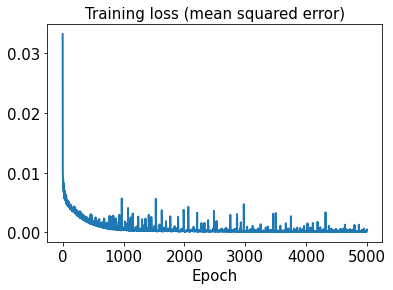

In [27]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

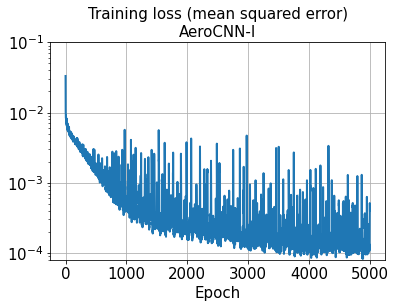

In [28]:
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)\nAeroCNN-I', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.ylim([8e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

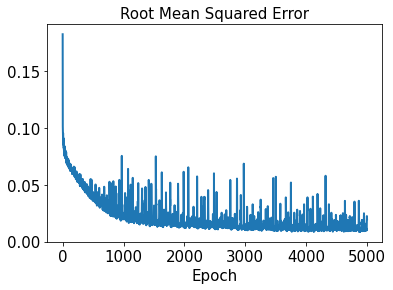

In [29]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

In [30]:
test_results = model.evaluate([x_train,aa_train])

47/47 [==============================] - 0s 2ms/step - loss: 9.7012e-06 - rmse: 0.0000e+00


In [31]:
decoded_train = model.predict([x_train,aa_train])

47/47 [==============================] - 0s 2ms/step


In [32]:
decoded_test = model.predict([x_test, aa_test])

20/20 [==============================] - 0s 2ms/step


In [33]:
error_train_abs = np.abs(decoded_train - y_train)

In [34]:
error_test_abs = np.abs(decoded_test - y_test)

In [35]:
error_train_Cl_abs = np.abs(decoded_train[:,0,:] - y_train[:,0,:])

In [36]:
error_train_Cd_abs = np.abs(decoded_train[:,1,:] - y_train[:,1,:])

In [37]:
error_test_Cl_abs = np.abs(decoded_test[:,0,:] - y_test[:,0,:])

In [38]:
error_test_Cd_abs = np.abs(decoded_test[:,1,:] - y_test[:,1,:])

In [39]:
decoded_train.shape

(1488, 2, 1)

In [40]:
os.chdir("D:\\TrainedModels\\20220929")
model.save('AeroCNN-I_2FClayer_512kernels.h5', overwrite=True, include_optimizer=True, save_format='h5')

In [41]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.032525586645879685


In [42]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.19856151850205472


In [43]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,0,:] - y_train[:,0,:])**2) / np.sum(y_train[:,0,:]**2))
print(l2_error_Cl_train)

0.03043139179295838


In [44]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,1,:] - y_train[:,1,:])**2) / np.sum(y_train[:,1,:]**2))
print(l2_error_Cd_train)

0.06809972315856441


In [45]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,0,:] - y_test[:,0,:])**2) / np.sum(y_test[:,0,:]**2))
print(l2_error_Cl_test)

0.1880681421043127


In [46]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,1,:] - y_test[:,1,:])**2) / np.sum(y_test[:,1,:]**2))
print(l2_error_Cd_test)

0.3726477972093385


In [47]:
l2_error_train_list = []
for i in range(0, len(aa_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)
print(l2_error_train_list)

[0.012329935377536606, 0.02543494813997304, 0.05013085253428066, 0.24127056819214113, 0.08870698424671851, 0.016587815636419513, 0.014111403562120926, 0.0138571969681981, 0.008606991218743794, 0.015702582604565102, 0.010336328879485284, 0.02063746930329718, 0.013198585720504863, 0.009237409291454434, 0.0129662901830644, 0.007862822890152603, 0.022487308947458644, 0.021422942994411175, 0.008249455343695334, 0.026750300855803134, 0.14872371236534798, 0.10148908294904312, 0.026649581204692466, 0.011432547402862842, 0.03085848511291986, 0.008239603290301531, 0.02286931501062811, 0.014151053947060059, 0.012639540108308934, 0.004837660376873624, 0.013650109673781143, 0.010417661291868554, 0.0733576071154328, 0.08630368832646593, 0.05253970095718429, 0.054026718060273954, 0.03506219715939306, 0.08369222273587522, 0.013345783181038656, 0.009339884941747334, 0.006663088609244366, 0.019358252383703003, 0.030677085042498373, 0.027974005695480683, 0.015222443070365601, 0.03720190379558238, 0.01607

In [48]:
l2_error_test_list = []
for i in range(0, len(aa_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)
print(l2_error_test_list)

[0.07248798953464991, 0.025460772081165126, 0.11744294103193159, 0.11163990815255738, 0.20763116042426438, 0.6009459154533101, 0.18685915070961637, 0.14618864647519167, 0.10701243200483038, 0.061956693859952165, 0.41094506263650304, 0.07949122798706722, 0.10378770919892764, 0.4181582174770104, 0.140205018693635, 0.20870926924412153, 0.04982244943769069, 0.10910909109460448, 0.11770195039230123, 0.16823058774351832, 1.7025806227209412, 0.1993252078395306, 0.10685295077967111, 0.08815700045929241, 0.0764564363146457, 0.09429981285698065, 0.10357242605670686, 0.1054869927335511, 0.06775899648608506, 0.04775864918383972, 0.25619062925248454, 0.2476027621031822, 0.19277688946081065, 0.0380460278682321, 0.04024122547686866, 0.0025205273110122965, 0.07457885748522612, 0.1410570741602533, 0.061766815267387934, 0.07529296734037871, 0.09534991736782741, 0.004296525135861971, 0.41005495606262815, 0.2609382111540706, 0.09449162906277982, 0.2987555452238803, 0.04702528561897979, 0.03294873778587481

In [49]:
l2_error_Cl_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cl_train_data = np.sqrt(np.sum((decoded_train[:,0,:][i] - y_train[:,0,:][i])**2) / np.sum(y_train[:,0,:][i]**2))
    l2_error_Cl_train_list.append(l2_error_Cl_train_data)
print(l2_error_Cl_train_list)

[0.012181936204457596, 0.019874415581373577, 0.04766958345711721, 0.2477660111373625, 0.0892177250494157, 0.015602140612187615, 0.012824293028802131, 0.01338426285275153, 0.007464416287422532, 0.014877520492152338, 0.004265515034966334, 0.01994364121292818, 0.013131638778127657, 0.009250779278118447, 0.011936700772075771, 0.007527023470489466, 0.008145285319783856, 0.02092402483348398, 0.0011354373359478082, 0.025603030832520014, 0.15014815930372744, 0.10198521825429793, 0.02649929079194524, 0.00981426914198177, 0.030874852107503854, 0.007774747607472934, 0.022326703096105543, 0.012568603522105174, 0.0024515424214165828, 0.0038434171368183236, 0.008071572919944505, 0.007591875277829478, 0.07499264697312391, 0.08737183661914392, 0.05251104870423649, 0.05345408612553375, 0.03483993791917631, 0.08466197187103909, 0.013352946714666731, 0.0068065344408886974, 0.002079814483867293, 0.015436982021727426, 0.029871813012832815, 0.02508289776935232, 0.01581675680763628, 0.03473489909435249, 0.01

In [50]:
l2_error_Cd_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cd_train_data = np.sqrt(np.sum((decoded_train[:,1,:][i] - y_train[:,1,:][i])**2) / np.sum(y_train[:,1,:][i]**2))
    l2_error_Cd_train_list.append(l2_error_Cd_train_data)
print(l2_error_Cd_train_list)

[0.04470540457873277, 0.3439163459589644, 0.23789798110401733, 0.015255715740322185, 0.03653968745538739, 0.11885336831971587, 0.18118949808971005, 0.13055016761902918, 0.1569556357043106, 0.16611327475585735, 0.2564775555973117, 0.12113795432543045, 0.027343981772180122, 0.006160344602396868, 0.06173617048556414, 0.021618384886654834, 0.4727339325449901, 0.12127307834776208, 0.19931641757007537, 0.1322115105217976, 0.10195649716407641, 0.06789858542485595, 0.06034291293310097, 0.16108112632907162, 0.00483079635967002, 0.07640090584374341, 0.11319322228096138, 0.11659501237810595, 0.16498922254159118, 0.03366554859704154, 0.09800246805478767, 0.050839292373540304, 0.03318582115885029, 0.03375342396332188, 0.056811740580847925, 0.15735145808515644, 0.05134518462144485, 0.03148934089434329, 0.009715301163356251, 0.19799393837120918, 0.19024245439349494, 0.18908714045122268, 0.07436084653001009, 0.06131483605981948, 0.0003282134457814571, 0.05513413950726434, 0.03888830094816081, 0.009436

In [51]:
l2_error_Cl_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cl_test_data = np.sqrt(np.sum((decoded_test[:,0,:][i] - y_test[:,0,:][i])**2) / np.sum(y_test[:,0,:][i]**2))
    l2_error_Cl_test_list.append(l2_error_Cl_test_data)
print(l2_error_Cl_test_list)

[0.07396034366981921, 0.02333534991511411, 0.11611956353045104, 0.1116025740598908, 0.2087087737038217, 0.6122165963709547, 0.1866352598683957, 0.14599639753314508, 0.10709012848177953, 0.06211495683733597, 0.41739115456485837, 0.0813755431302176, 0.10695814501774997, 0.4302168734493587, 0.14478280876047028, 0.21995229748515688, 0.046322456783129344, 0.10781648557431348, 0.11529858617483893, 0.1653088893104655, 2.430112109314559, 0.19951192227705486, 0.10692682138539476, 0.08815978270105465, 0.07642539074644103, 0.09423053304122386, 0.10337598334039663, 0.10513088925333211, 0.06463256379429821, 0.040550883947430866, 0.25510201871191496, 0.21541404301416855, 0.19605798283973117, 0.003233243193641455, 0.0398754878449481, 5.178952243166832e-05, 0.07294623667711105, 0.1427753352220618, 0.0613203533658822, 0.0752561075094236, 0.09538335073754842, 0.001735586676261941, 0.41266069314480003, 0.26519092773004044, 0.09664001823943053, 0.2984652622243816, 0.046631557805065046, 0.02315015605841518

In [52]:
l2_error_Cd_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cd_test_data = np.sqrt(np.sum((decoded_test[:,1,:][i] - y_test[:,1,:][i])**2) / np.sum(y_test[:,1,:][i]**2))
    l2_error_Cd_test_list.append(l2_error_Cd_test_data)
print(l2_error_Cd_test_list)

[0.03365580001416817, 0.06567670877781219, 0.2621557737521082, 0.12434251563206856, 0.010986436923474447, 0.04550608959710704, 0.2641117496729399, 0.2605533606448706, 0.04149709837900295, 0.0055849789267140735, 0.03374016731302088, 0.029034617535996964, 0.04720819100316358, 0.2761855046601853, 0.09348311999697607, 0.11035517006536251, 0.561522711943461, 0.5088424580699787, 0.579412357310406, 0.46493597965628924, 0.324588938284888, 0.16623291754018243, 0.03390144921057145, 0.08459493553811814, 0.11760090275284679, 0.1778503307012954, 0.2623035008789239, 0.27826478042620506, 0.3912996455352645, 0.25777044568459395, 0.28079915253263443, 0.37826391127909564, 0.1186568955222027, 0.24365492131755534, 0.09201980489318537, 0.054050695589771935, 0.1823753430947561, 0.08956678790838024, 0.16174203389786387, 0.10470614990644435, 0.044120156963656496, 0.08241479220023802, 0.07087781014298204, 0.15726214598225208, 0.056410031640583676, 0.3020748187333159, 0.050356892574008154, 0.07063130438424253, 

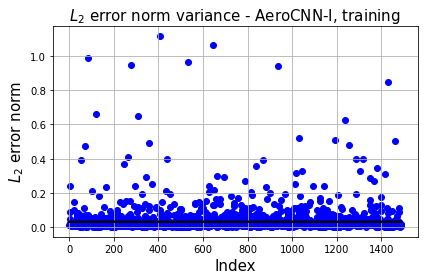

In [53]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, training', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

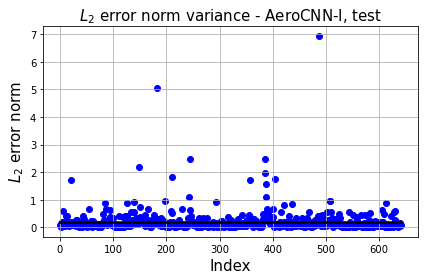

In [54]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

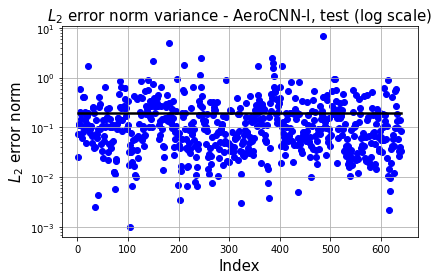

In [55]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-I, test (log scale)', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

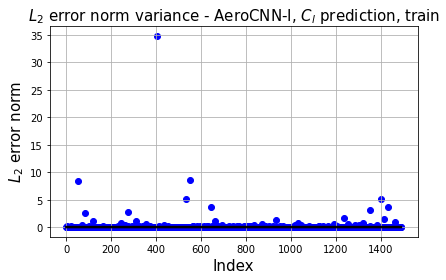

In [56]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_l$ prediction, train', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

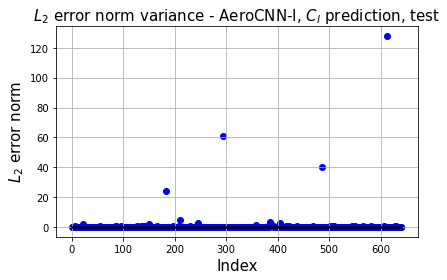

In [57]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_l$ prediction, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

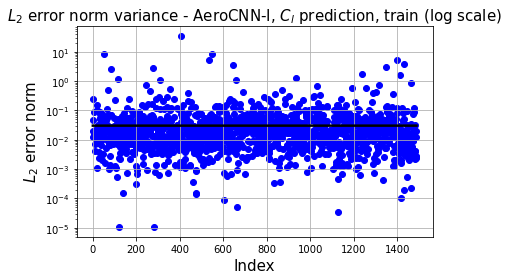

In [58]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_l$ prediction, train (log scale)\n512 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

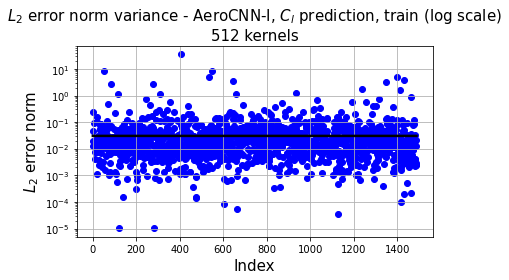

In [74]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_l$ prediction, train (log scale)\n512 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

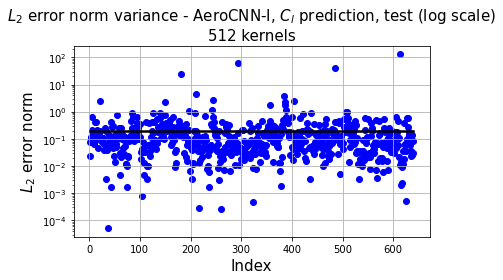

In [75]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_l$ prediction, test (log scale)\n512 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

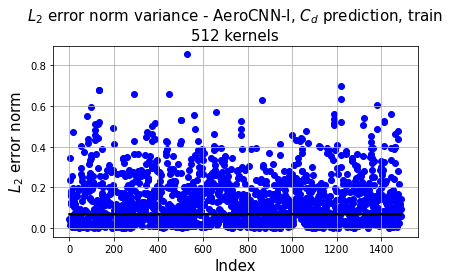

In [76]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cd_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cd_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_d$ prediction, train\n512 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

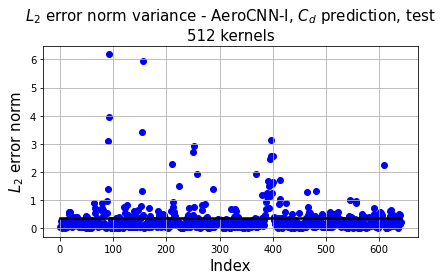

In [77]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cd_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cd_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_d$ prediction, test\n512 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

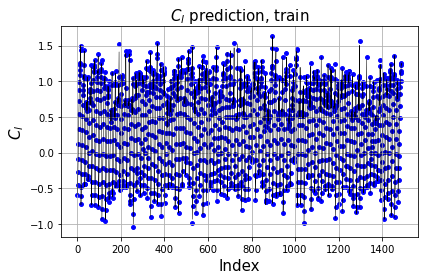

In [62]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,0,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title(r'$C_l$ prediction, train', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

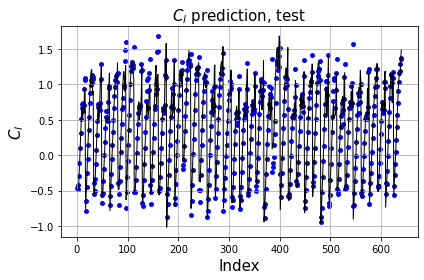

In [63]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,0,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title(r'$C_l$ prediction, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

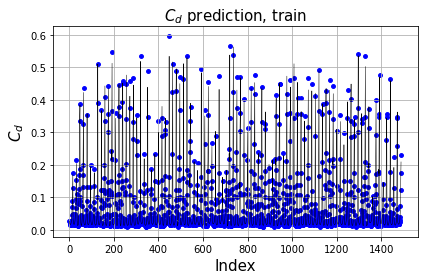

In [64]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,1,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title(r'$C_d$ prediction, train', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

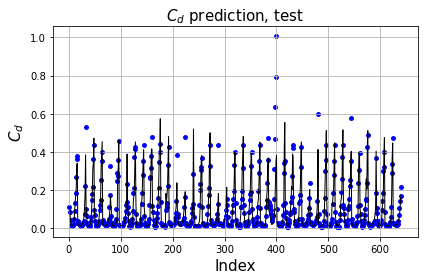

In [65]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,1,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title(r'$C_d$ prediction, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

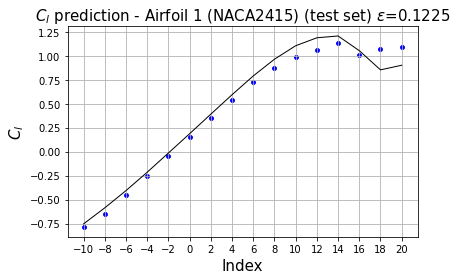

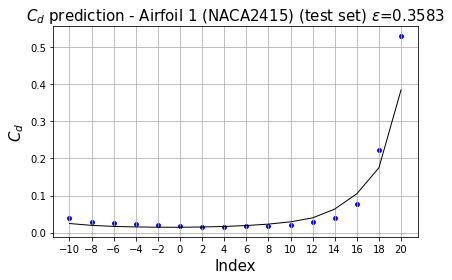

In [79]:
airfoiltest1_predict = decoded_test[16*1:16*2]

airfoiltest1_cl=y_test[16*1:16*2,0,:]
airfoiltest1_cd=y_test[16*1:16*2,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest1_predict[:,0,:] - airfoiltest1_cl)**2) / np.sum(airfoiltest1_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest1_predict[:,1,:] - airfoiltest1_cd)**2) / np.sum(airfoiltest1_cd**2))


plt.plot(alpha, airfoiltest1_cl.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,0,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*16][0])[2:-1], epsilonCl), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest1_cd.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,1,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*16][0])[2:-1], epsilonCd), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

In [67]:
decoded_test.shape

(640, 2, 1)

In [68]:
np.unique(geo_test)

array([b'NACA000834', b'NACA0010', b'NACA001034', b'NACA001264',
       b'NACA0024', b'NACA1408', b'NACA2408', b'NACA2411', b'NACA2415',
       b'NACA2418', b'NACA4412', b'NACA4415', b'NACA4421', b'NACA63010a',
       b'NACA63012a', b'NACA631412', b'NACA63210', b'NACA632415',
       b'NACA632615', b'NACA634221', b'NACA64008a', b'NACA64108',
       b'NACA64110', b'NACA6412', b'NACA64206', b'NACA64209',
       b'NACA64a210', b'NACA651412', b'NACA661212', b'NACA663218',
       b'RAE100', b'RAE101', b'RAE102', b'RAE2822', b'RAE5212',
       b'RAE5214', b'RAE69CK', b'RAF19', b'RAF31', b'RAF48'], dtype='|S32')

In [69]:
geo_test.shape[0]/16

40.0

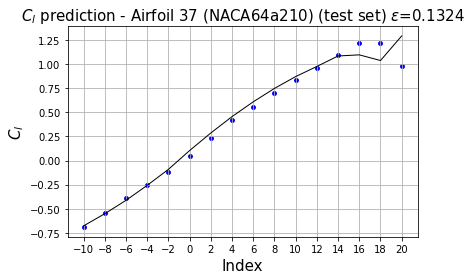

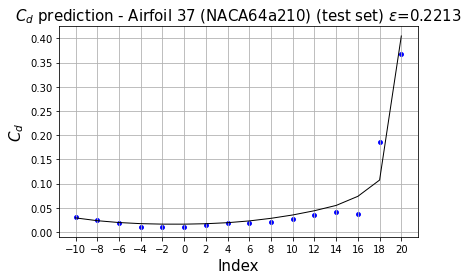

In [82]:
airfoiltest37_predict = decoded_test[16*36:16*37]

airfoiltest37_cl=y_test[16*36:16*37,0,:]
airfoiltest37_cd=y_test[16*36:16*37,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest37_predict[:,0,:] - airfoiltest37_cl)**2) / np.sum(airfoiltest37_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest37_predict[:,1,:] - airfoiltest37_cd)**2) / np.sum(airfoiltest37_cd**2))

plt.plot(alpha, airfoiltest37_cl.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest37_predict[:,0,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_l$ prediction - Airfoil 37 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[37*16][0])[2:-1], epsilonCl), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest37_cd.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest37_predict[:,1,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_d$ prediction - Airfoil 37 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[37*16][0])[2:-1], epsilonCd), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

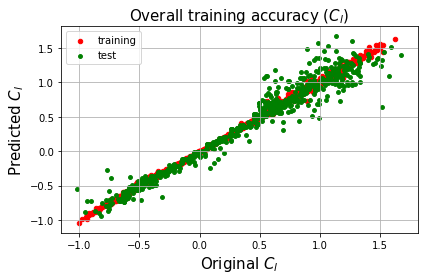

In [71]:
plt.scatter(y_train[:,0,:], decoded_train[:,0,:], c='r', s=20)
plt.scatter(y_test[:,0,:], decoded_test[:,0,:], c='g', s=15)
plt.xlabel('Original $C_l$', fontsize=15)
plt.ylabel('Predicted $C_l$', fontsize=15)
plt.title('Overall training accuracy ($C_l$)', fontsize=15)

plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

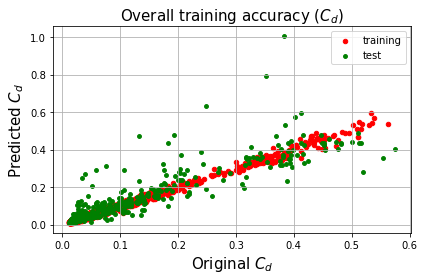

In [72]:
plt.scatter(y_train[:,1,:], decoded_train[:,1,:], c='r', s=20)
plt.scatter(y_test[:,1,:], decoded_test[:,1,:], c='g', s=15)
plt.xlabel('Original $C_d$', fontsize=15)
plt.ylabel('Predicted $C_d$', fontsize=15)
plt.title('Overall training accuracy ($C_d$)', fontsize=15)
plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

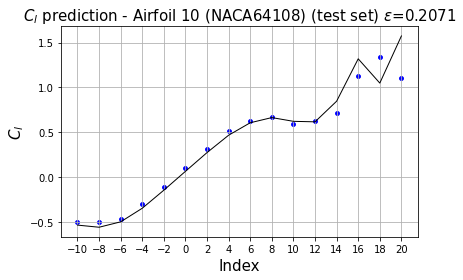

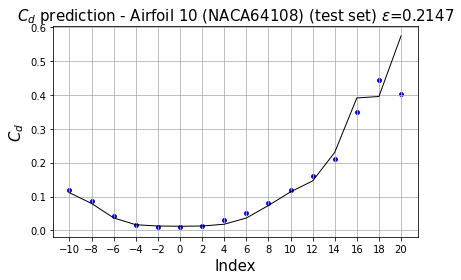

In [73]:
airfoiltest1_predict = decoded_test[16*10:16*11]

airfoiltest1_cl=y_test[16*10:16*11,0,:]
airfoiltest1_cd=y_test[16*10:16*11,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest1_predict[:,0,:] - airfoiltest1_cl)**2) / np.sum(airfoiltest1_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest1_predict[:,1,:] - airfoiltest1_cd)**2) / np.sum(airfoiltest1_cd**2))

plt.plot(alpha, airfoiltest1_cl.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,0,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 10 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[10*16][0])[2:-1], epsilonCl), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest1_cd.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,1,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 10 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[10*16][0])[2:-1], epsilonCd), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
airfoiltest1_predict = decoded_test[16*10:16*11]

airfoiltest1_cl=y_test[16*10:16*11,0,:]
airfoiltest1_cd=y_test[16*10:16*11,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest1_predict[:,0,:] - airfoiltest1_cl)**2) / np.sum(airfoiltest1_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest1_predict[:,1,:] - airfoiltest1_cd)**2) / np.sum(airfoiltest1_cd**2))

plt.plot(alpha, airfoiltest1_cl.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,0,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 10 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[10*16][0])[2:-1], epsilonCl), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest1_cd.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,1,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 10 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[10*16][0])[2:-1], epsilonCd), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()